In [18]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [19]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

x_train = train_dataset.data
y_train = train_dataset.targets

test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

x_test = test_dataset.data
y_test = test_dataset.targets

In [20]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [21]:
train_dataset.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [22]:
print('x train:', x_train.shape)
print('y train:', y_train.shape)
print('x test:', x_test.shape)
print('y test:', y_test.shape)

x train: torch.Size([60000, 28, 28])
y train: torch.Size([60000])
x test: torch.Size([10000, 28, 28])
y test: torch.Size([10000])


In [23]:
# build the model
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
# no need for final softmax!

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

cpu


Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=10, bias=True)
)

In [25]:
# loss and optimizer
criterion = nn.CrossEntropyLoss() # remember, for multiclass classification!!
optimizer = torch.optim.Adam(model.parameters())

In [26]:
# data loader
# useful bc it automatically generates batches in the training loop
batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size= batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [27]:
tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                         batch_size=1,
                                         shuffle=True)
for x, y in tmp_loader:
    # print(x, y)
    print(x.shape)
    print(y.shape)
    break

torch.Size([1, 1, 28, 28])
torch.Size([1])


In [28]:
train_dataset.transform(train_dataset.data.numpy()).max()

tensor(1.)

In [29]:
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
    train_loss = []
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # reshape the input
        inputs = inputs.view(-1, 784)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # backward and optimize
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    # get train loss and test loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        # reshape the input
        inputs = inputs.view(-1, 784)

        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss.append(loss.item())
    # get train loss and test loss
    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss


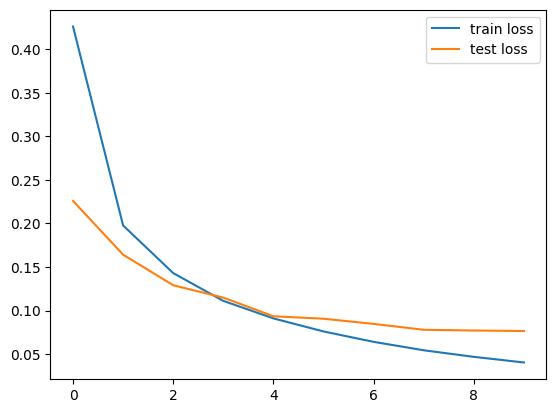

In [30]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [36]:
n_correct = 0
n_total = 0

for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum()
    n_total += targets.shape[0]

train_accuracy = n_correct / n_total

n_correct = 0
n_total = 0

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    inputs = inputs.view(-1, 784)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    n_correct += (predictions == targets).sum()
    n_total += targets.shape[0]

test_accuracy = n_correct / n_total

print(f"Train accuracy:\t{train_accuracy:.3f}")
print(f"Test accuracy:\t{test_accuracy:.3f}")

Train accuracy:	0.992
Test accuracy:	0.977


In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Confusion matrix, without normalization
[[ 964    0    1    1    1    4    3    1    2    3]
 [   0 1125    3    1    0    0    3    0    3    0]
 [   4    1 1010    1    1    0    2    6    6    1]
 [   0    0    3  993    1    5    0    4    2    2]
 [   0    0    4    1  958    0    5    2    1   11]
 [   2    0    0    6    1  875    4    0    3    1]
 [   4    3    1    1    2    5  942    0    0    0]
 [   0    5    8    5    2    0    0 1001    1    6]
 [   4    2    5   13    5    5    4    4  923    9]
 [   2    5    0    8    7    3    0    4    1  979]]


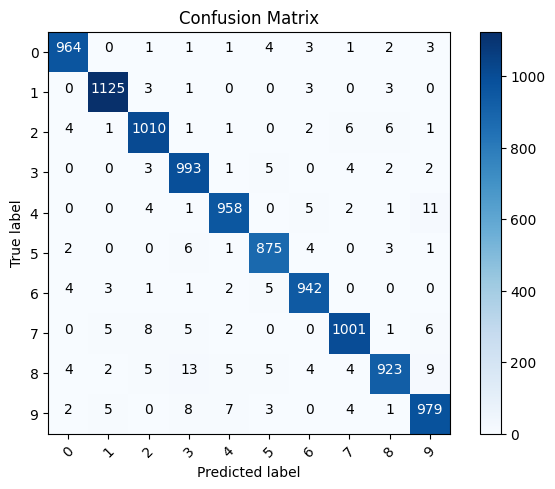

In [38]:
# get all predictions in an array and plot confusion matrix
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])

for inputs, targets in test_loader:
    # move data to GPU
    inputs = inputs.to(device)
    # reshape the input
    inputs = inputs.view(-1, 784)
    # forward pass
    outputs = model(inputs)
    # get prediction
    _, predictions = torch.max(outputs, 1)
    # update p test
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))


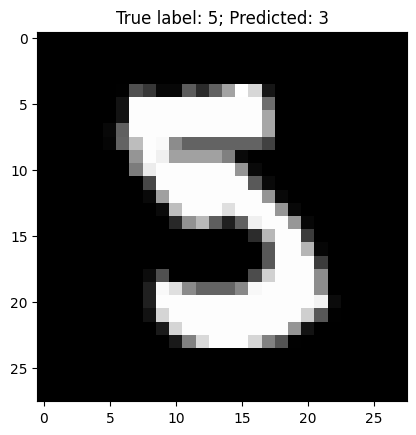

In [61]:
# show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title(f'True label: {y_test[i]:d}; Predicted: {int(p_test[i]):d}');